# Quality check for star-particle integration

How do we ensure that the orbital integration went well for our star particles? We need to ensure that the relative error is good. Does it need to be time-reversable? what about computational cost? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
from astropy import units as u
from astropy import constants as const
import numericalErrorFunctions as NEF
import datetime
import multiprocessing as mp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# Dynamical time scales

What are the time scales involved in the problem? What should our expectation be for the time scales for integrating a whole globular cluster? for integrating an individual star particle? 

Below, I will also try to find some that are disrupted, which could be ones whose internal time scales are longer than their crossing times. 

In [2]:
GCdata          =   tstrippy.Parsers.baumgardtMWGCs().data
MWparams        =   tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      =   tstrippy.Parsers.potential_parameters.MWreferenceframe()
x,y,z,vx,vy,vz  =   NEF.load_globular_clusters_in_galactic_coordinates(MWrefframe)
G = const.G
G=G.to(tstrippy.Parsers.unitbasis['G'])

In [3]:
# get the crossing time of the clusters 
vGCs = np.sqrt(vx**2 + vy**2 + vz**2)
rGCS = np.sqrt(x**2 + y**2 + z**2)
tcrossGCs = ((rGCS / vGCs) * u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
# get the internal dynamical time 
tdyn=np.sqrt(GCdata['rh_m']**3 / (G*GCdata['Mass'])).to(u.yr)

In [4]:
nbins = int(np.ceil(len(GCdata)))
binednges = 10**np.linspace(np.log10(tdyn.min().value), np.log10(tcrossGCs.max().value), nbins+1)

In [5]:
indexes = [tdyn.argmin(), np.argmin(np.abs(tdyn-np.median(tdyn))), tdyn.argmax()]
NP = 10000
labels = [r"$\mathrm{Most~dense}$", r"$\mathrm{Median}$", r"$\mathrm{Least~dense}$"]
index = indexes[0]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmin=tcrossP.min()
index= indexes[-1]
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
tcrossP = rp/vp
tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
tmax=tcrossP.max()
nbins = int(np.sqrt(NP))
bins = 10**np.linspace(np.log10(tmin.value), np.log10(tmax.value), nbins+1)

1.423078026509687
1.4686334588710033
1.4641006684707252


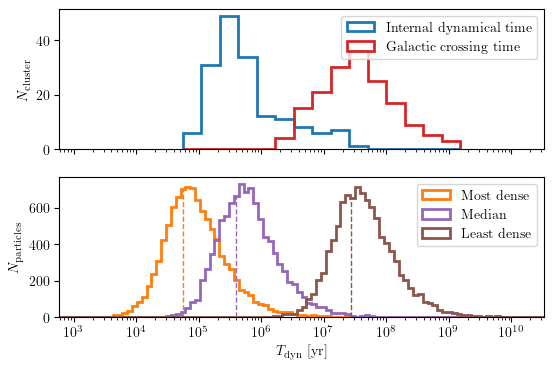

In [6]:
fig,axis=plt.subplots(2,1,figsize=(8.25-2,4),sharex=True, gridspec_kw={'height_ratios': [1, 1]})
axis[0].hist(tdyn.value, bins=binednges,  histtype='step', color='tab:blue', lw=2, label=r"$\mathrm{Internal~dynamical~time}$")
axis[0].hist(tcrossGCs.value, bins=binednges,  histtype='step', color='tab:red', lw=2, label=r"$\mathrm{Galactic~crossing~time}$")
axis[0].set_xscale('log')
axis[1].set_xlabel(r'$T_{\mathrm{dyn}}~[\mathrm{yr}]$', fontsize="medium")
axis[0].set_ylabel(r'$N_{\mathrm{cluster}}$', fontsize="medium")
ylims = axis[0].get_ylim()
axis[0].set_ylim(0, ylims[1])
# axis[0].set_xlim(3e4,5e9)
axis[0].legend(fontsize="medium", loc='best')

colors = ['tab:orange', 'tab:purple', 'tab:brown']
bin_ceneters = 0.5*(bins[1:] + bins[:-1])
for i in range(len(indexes)):
    index = indexes[i]
    xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G.value,GCdata['Mass'][index].value,GCdata['rh_m'][index].value, NP)
    rp,vp = np.sqrt(xp**2 + yp**2 + zp**2), np.sqrt(vxp**2 + vyp**2 + vzp**2)
    tcrossP = rp/vp
    tcrossP = (tcrossP*u.Unit(tstrippy.Parsers.unitbasis['time'])).to(u.yr)
    counts,_,_=axis[1].hist(tcrossP.value, bins=bins, histtype='step', lw=2, label=labels[i],color=colors[i])
    # find the counts at the median tdyn 
    myindex = np.argmin(np.abs(bin_ceneters - tdyn[index].value))
    axis[1].vlines(tdyn[index].value, 0, counts[myindex], color=colors[i], linestyle='--', lw=1, )
    print(np.median(tcrossP).value/tdyn[index].value)

axis[1].set_xlim(tmin.value, tmax.value)
axis[1].legend(fontsize="medium", loc='best')
axis[1].set_xscale('log')
axis[1].set_ylabel(r'$N_{\mathrm{particles}}$', fontsize="medium")

fig.savefig("../../images/GCsystemCharacteristicTimes.png", bbox_inches='tight', dpi=300)

We see that the tails overlap, are there any cluster's whose internal crossing time is longer than the galactic crossing time?

In [7]:
print(np.sum(tdyn > tcrossGCs))

0


no, there are not. Good to know. What are the ratio's? 

In [8]:
least_stable_threshold,most_stable_threshold = 10,500
ratio = tcrossGCs/tdyn
criteria=ratio < least_stable_threshold
least_stable = GCdata['Cluster'][criteria]
least_stable_ratio = ratio[criteria]
least_stable_sort = np.argsort(least_stable_ratio)
least_stable_sorted = least_stable[least_stable_sort]
criteria = ratio > most_stable_threshold
most_stable = GCdata['Cluster'][criteria]
most_stable_ratio = ratio[criteria]
most_stable_sort = np.argsort(most_stable_ratio)
most_stable_sorted = most_stable[most_stable_sort]

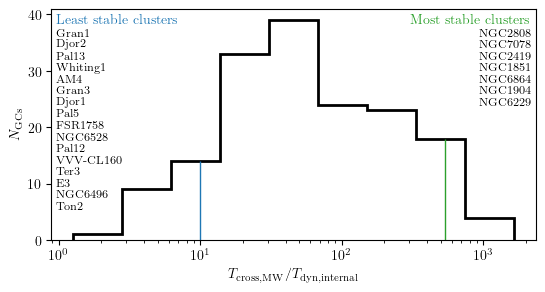

In [9]:
bins = np.logspace(np.log10(ratio.min().value), np.log10(ratio.max().value) , int(np.sqrt(nbins)))
centers = 0.5*(bins[1:] + bins[:-1])
fig,axis=plt.subplots(1,1,figsize=(8.25-2,3))
counts,_,_=axis.hist(ratio.value, bins=bins, histtype='step', lw=2, color='black')
# find the intersection of the counts with the median tdyn
index_least = np.argmin(np.abs(centers-least_stable_threshold))
index_most = np.argmin(np.abs(centers-most_stable_threshold))
axis.vlines(centers[index_least], 0, counts[index_least], color='tab:blue', linestyle='-', lw=1, )
axis.vlines(centers[index_most], 0, counts[index_most], color='tab:green', linestyle='-', lw=1,)
axis.set_xscale('log')
axis.set_xlabel(r'$T_{\mathrm{cross,MW}}/T_{\mathrm{dyn,internal}}$', fontsize="medium")
axis.set_ylabel(r'$N_{\mathrm{GCs}}$', fontsize="medium")
axis.text(0.01, 0.925, r"$\mathrm{Least~stable~clusters}$", fontsize="medium", color='tab:blue',transform=axis.transAxes,ha='left', va='bottom')
for i in range(len(least_stable)):
    axis.text(0.01, 0.875 - i*0.05, least_stable_sorted[i], fontsize="small", color='black',transform=axis.transAxes,ha='left', va='bottom')

axis.text(0.99, 0.925, r"$\mathrm{Most~stable~clusters}$", fontsize="medium", color='tab:green',transform=axis.transAxes,ha='right', va='bottom')
for i in range(len(most_stable)):
    axis.text(0.99, 0.875 - i*0.05, most_stable_sorted[i], fontsize="small", color='black',transform=axis.transAxes,ha='right', va='bottom')

fig.savefig("../../images/GCsystemStabilityDynamicalTimeRatios.png", bbox_inches='tight', dpi=300)

what's the most typical globular cluster?

In [10]:
dTdyn = (np.log10(tdyn.value) - np.log10(np.median(tdyn).value)) / np.log10(np.median(tdyn).value)
dCross = (np.log10(tcrossGCs.value) - np.log10(np.median(tcrossGCs).value)) / np.log10(np.median(tcrossGCs).value)
typicaldex=np.argmin(np.abs(dTdyn) + np.abs(dCross))
# medianIndex = np.argmin(np.abs(ratio-np.median(ratio)))
# typicalGC = GCdata['Cluster'][medianIndex]
# GCdata['Mass'][medianIndex]
print(f"Most typical globular cluster: {GCdata['Cluster'][typicaldex]}")
print(f"Mass: {GCdata['Mass'][typicaldex]} Msun")
print(f"Internal dynamical time: {tdyn[typicaldex]}")
print(f"Galactic crossing time: {tcrossGCs[typicaldex]}")
print(f"Ratio: {tcrossGCs[typicaldex]/tdyn[typicaldex]}")
print(f"R half mass: {GCdata['rh_m'][typicaldex]}")

Most typical globular cluster: NGC6760
Mass: 286000.0 solMass Msun
Internal dynamical time: 383398.89404155954 yr
Galactic crossing time: 31467033.00751118 yr
Ratio: 82.07387526814365
R half mass: 0.00574 kpc


In [16]:
# get some other typical clusters 
metric = np.abs(dTdyn) + np.abs(dCross)
idxs=np.argsort(np.abs(dTdyn) + np.abs(dCross))
GCdata['Cluster'][idxs]
print("some of the most typical clusters by stability ratio")
for i in range(5):
    print(GCdata['Cluster'][idxs[i]],metric[idxs[i]], tdyn[idxs[i]], tcrossGCs[idxs[i]])

some of the most typical clusters by stability ratio
NGC6760 0.0018449005823754077 383398.89404155954 yr 31467033.00751118 yr
NGC6218 0.004971833457713373 377401.2599695203 yr 30449852.116946597 yr
NGC6934 0.009741833482753752 393506.368081583 yr 37121169.77788263 yr
NGC6171 0.012364829342188785 432418.9645355858 yr 34224555.84814521 yr
NGC6254 0.013754278755766035 355038.57851801836 yr 28398514.382304374 yr


## 

## What is a good timestep for an isolated cluster?

Normalize the system to it's own length, G, and it's own mass.

what is the a typical globular cluster just to get an idea of the timescales involved?

In [10]:
integration_time = int(5e9/np.median(tdyn).value)
print("Number of dynamical times for our experiment", integration_time)

Number of dynamical times for our experiment 12843


In [11]:
G,M,a = 1,1,1
NP = int(1e2)
tau = np.sqrt(a**3 / (G*M))

how to pick the time step? 

$$ \Delta t = \frac{T}{2^{k-1}} $$

where $N=2^{k-1}$, and $k$ is the number of intervals and $N$ is the number of steps. Note that we want the timestep to be some fraction of the dynamical time: 

$$ \alpha \Delta t = \tau$$

where $0<\alpha<1$. So, given an $\alpha$, we want to find the number of steps such that $k$ and $N$ are integers. This becomes: 

$$ \log_2 \left(\frac{T}{\alpha \tau} \right) + 1 < k$$


This means, we can take the expression on the left side of the inequality and round it up for the lowest possible value of $k$. If $\alpha = 1/100$ and $T = 1200\tau$, Then $k$ becomes: 